In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf
import os

In [2]:
local_weight_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

In [3]:
# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weight_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [31]:
# Choose `mixed_6` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed6')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [35]:
x = layers.experimental.preprocessing.Rescaling(1./255)
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x) 
x = layers.Dense(512, activation='relu')(x)  
x = layers.Dense (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [37]:
from tensorflow.keras.optimizers import Adam
# Set the training parameters
model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [38]:
base_dir = '../Dataset/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training acne pictures
train_acne_dir = os.path.join(train_dir, 'acne') 

# Directory with training normal pictures
train_normal_dir = os.path.join(train_dir, 'normal2') 

# Directory with validation acne pictures
validation_acne_dir = os.path.join(validation_dir, 'acne') 

# Directory with validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'normal2')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['acne2', 'normal2'],
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         classes=['acne', 'normal2'],
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 504 images belonging to 2 classes.
Found 339 images belonging to 2 classes.


In [39]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and (logs.get('accuracy') > 0.99 or logs.get('accuracy') < 0.55):
            print("\nReached 95% accuracy, so cancelling training!")
            self.model.stop_training = True

In [40]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 10,
            epochs = 50,
            validation_steps = 2,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/50
10/10 - 7s - loss: 0.2594 - accuracy: 0.9150 - val_loss: 1.2645 - val_accuracy: 0.6000 - 7s/epoch - 715ms/step
Epoch 2/50
10/10 - 4s - loss: 0.1253 - accuracy: 0.9550 - val_loss: 2.2005 - val_accuracy: 0.6750 - 4s/epoch - 397ms/step
Epoch 3/50
10/10 - 4s - loss: 0.2237 - accuracy: 0.9400 - val_loss: 0.3445 - val_accuracy: 0.8250 - 4s/epoch - 397ms/step
Epoch 4/50
10/10 - 4s - loss: 0.1422 - accuracy: 0.9620 - val_loss: 1.4757 - val_accuracy: 0.6500 - 4s/epoch - 432ms/step
Epoch 5/50
10/10 - 4s - loss: 0.1317 - accuracy: 0.9565 - val_loss: 1.9713 - val_accuracy: 0.7500 - 4s/epoch - 416ms/step
Epoch 6/50
10/10 - 4s - loss: 0.1525 - accuracy: 0.9650 - val_loss: 1.3383 - val_accuracy: 0.6250 - 4s/epoch - 404ms/step
Epoch 7/50
10/10 - 4s - loss: 0.1563 - accuracy: 0.9550 - val_loss: 1.0750 - val_accuracy: 0.6750 - 4s/epoch - 394ms/step
Epoch 8/50
10/10 - 4s - loss: 0.0848 - accuracy: 0.9728 - val_loss: 0.7640 - val_accuracy: 0.6750 - 4s/epoch - 392ms/step
Epoch 9/50
10/10 - 4s - 

----

### Visualizing Accuracy Plot

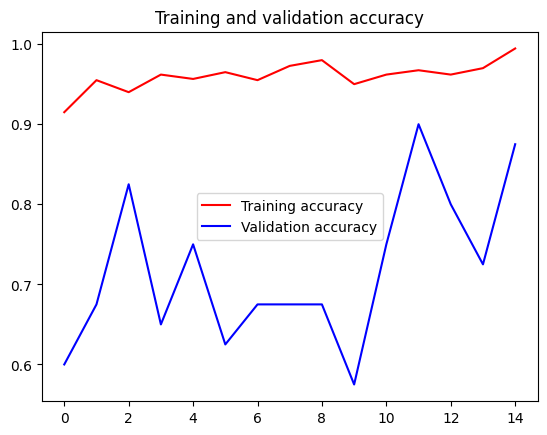

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

----

### Try Input Image

In [56]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
# from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

root = tk.Tk()
root.withdraw()
uploaded = filedialog.askopenfilename()
 
  # predicting images
path = uploaded
img = load_img(path, target_size=(150, 150))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)

    
if classes[0]>0.5:
  print("no acne", classes[0])
  print()
else:
  print("Your face have acne with probabilty", (1-classes[0])*100, '%')
  print()
 

1/1 [==============================] - 0s 37ms/step
Your face have acne with probabilty [99.98503] %



-----

### Convert and Save Model

In [ ]:
model.save('acnedetection.h5')

In [ ]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
new_model= tf.keras.models.load_model(filepath="acnedetection.h5")

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('acnedetection.tflite', 'wb') as f:
  f.write(tflite_model)